In [ ]:
import os
import pandas as pd
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import numpy as np
from sklearn.model_selection import train_test_split


### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_dir = "/content/drive/MyDrive/Rezised_dataset"

file_paths = []
labels = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

label2idx = {label: idx for idx, label in enumerate(sorted(set(df['label'])))}
df['label_idx'] = df['label'].map(label2idx)

# Split into labeled and unlabeled
df_labeled, df_unlabeled = train_test_split(df, test_size=0.7, stratify=df['label_idx'], random_state=42)
df_unlabeled = df_unlabeled.reset_index(drop=True)
df_labeled = df_labeled.reset_index(drop=True)


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
ROOT_DIR = "/content/drive/MyDrive/rezised_dataset"
if not os.path.exists(ROOT_DIR):
    print(f"Warning: {ROOT_DIR} not found. Using a dummy directory structure for testing.")
    ROOT_DIR = "dummy_dataset"
    os.makedirs(os.path.join(ROOT_DIR, "ClassA"), exist_ok=True)
    os.makedirs(os.path.join(ROOT_DIR, "ClassB"), exist_ok=True)
    os.makedirs(os.path.join(ROOT_DIR, "ClassC"), exist_ok=True)
    for i in range(60): #
        Image.new('RGB', (100, 100), color = 'red').save(os.path.join(ROOT_DIR, "ClassA", f"a{i}.jpg"))
        Image.new('RGB', (100, 100), color = 'blue').save(os.path.join(ROOT_DIR, "ClassB", f"b{i}.jpg"))
        Image.new('RGB', (100, 100), color = 'green').save(os.path.join(ROOT_DIR, "ClassC", f"c{i}.jpg"))


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE_LABELED = 8
BATCH_SIZE_UNLABELED = 16
BATCH_SIZE_EVAL = 16
NUM_EPOCHS = 30
LR = 1e-4
EMA_DECAY = 0.999
CONSISTENCY_WEIGHT_MAX = 15.0
CONSISTENCY_RAMPUP_EPOCHS = 7

VAL_SIZE = 0.15
TEST_SIZE = 0.15
LABELED_RATIO_OF_TRAIN_POOL = 0.3

# --- 1. Data Loading and Preprocessing ---
file_paths = []
labels = []

for class_name in os.listdir(ROOT_DIR):
    class_dir = os.path.join(ROOT_DIR, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(class_dir, image_name))
                labels.append(class_name)

if not file_paths:
    raise ValueError(f"No images found in {ROOT_DIR}. Please check the path and image extensions.")

df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

label_set = sorted(set(df['label']))
label2idx = {label: idx for idx, label in enumerate(label_set)}
idx2label = {idx: label for label, idx in label2idx.items()}
NUM_CLASSES = len(label2idx)
df['label_idx'] = df['label'].map(label2idx)

print(f"Total images found: {len(df)} belonging to {NUM_CLASSES} classes: {label2idx}")

# --- Data Splitting (Train_Pool, Validation, Test) ---
min_samples_per_class_overall = 5
df_counts = df['label_idx'].value_counts()
if (df_counts < min_samples_per_class_overall).any() or len(df) < NUM_CLASSES * 10:
    print("Warning: Dataset or some classes are very small. Stratification might be difficult or lead to tiny splits.")
    if len(df) > NUM_CLASSES * 3 :
        df_labeled, df_temp = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)
        df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label_idx'], random_state=42)
        df_unlabeled = pd.DataFrame(columns=df.columns)
        print("Fallback split: 80% Labeled Train, 10% Val, 10% Test. No unlabeled data.")
    else:
        df_labeled = df.copy()
        df_unlabeled = pd.DataFrame(columns=df.columns)
        df_val = pd.DataFrame(columns=df.columns)
        df_test = pd.DataFrame(columns=df.columns)
        print("Fallback split: All data as Labeled Train. No Val/Test/Unlabeled data. SSL aspects will be limited.")

else:
    # First, split out the test set
    df_remaining, df_test = train_test_split(
        df,
        test_size=TEST_SIZE,
        stratify=df['label_idx'],
        random_state=42
    )
    # Next, split the remaining into validation and the (labeled+unlabeled) training pool
    # The val_size needs to be adjusted because it's a percentage of the original total
    relative_val_size = VAL_SIZE / (1.0 - TEST_SIZE)
    df_train_pool, df_val = train_test_split(
        df_remaining,
        test_size=relative_val_size,
        stratify=df_remaining['label_idx'],
        random_state=42
    )
    # Finally, split the training pool into labeled and unlabeled
    # Check if train_pool is large enough for the desired LABELED_RATIO_OF_TRAIN_POOL
    if len(df_train_pool) * LABELED_RATIO_OF_TRAIN_POOL < NUM_CLASSES or \
       len(df_train_pool) * (1-LABELED_RATIO_OF_TRAIN_POOL) < NUM_CLASSES :
        print(f"Warning: Train pool (size {len(df_train_pool)}) too small for desired labeled/unlabeled ratio while maintaining all classes. Using all of train_pool as labeled.")
        df_labeled = df_train_pool.copy()
        df_unlabeled = pd.DataFrame(columns=df_train_pool.columns)
    else:
        try:
            df_labeled, df_unlabeled = train_test_split(
                df_train_pool,
                test_size=(1.0 - LABELED_RATIO_OF_TRAIN_POOL), # test_size = unlabeled_ratio
                stratify=df_train_pool['label_idx'],
                random_state=42
            )
        except ValueError:
             print(f"Warning: Stratification failed for labeled/unlabeled split. Using all of train_pool as labeled.")
             df_labeled = df_train_pool.copy()
             df_unlabeled = pd.DataFrame(columns=df_train_pool.columns)


df_labeled = df_labeled.reset_index(drop=True)
df_unlabeled = df_unlabeled.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Number of labeled training samples: {len(df_labeled)}")
print(f"Number of unlabeled training samples: {len(df_unlabeled)}")
print(f"Number of validation samples: {len(df_val)}")
print(f"Number of test samples: {len(df_test)}")

# --- 2. Transforms ---
transform_weak = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_strong = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Custom Dataset ---
class BetelDataset(Dataset):
    def __init__(self, dataframe, base_transform, strong_transform=None, is_unlabeled_set=False):
        self.dataframe = dataframe
        self.base_transform = base_transform # Weak for training, Eval for val/test
        self.strong_transform = strong_transform # Strong aug for student on unlabeled
        self.is_unlabeled_set = is_unlabeled_set

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        label = self.dataframe.iloc[idx]['label_idx'] if 'label_idx' in self.dataframe.columns and not self.dataframe.empty else -1


        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Error: Image not found at {img_path}")
            image = Image.new('RGB', (224, 224), color = 'black')

        if self.is_unlabeled_set and self.strong_transform:
            img_weak_aug = self.base_transform(image) # For teacher
            img_strong_aug = self.strong_transform(image) # For student
            return (img_weak_aug, img_strong_aug), label # Label is for bookkeeping, not directly used in loss for unlabeled
        else:
            # For labeled training, validation, or test
            return self.base_transform(image), label

# --- 4. Model Definition (DenseNet201) ---
def create_densenet_model(num_classes, pretrained=True):
    model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1 if pretrained else None)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

student_model = create_densenet_model(NUM_CLASSES).to(DEVICE)
teacher_model = create_densenet_model(NUM_CLASSES).to(DEVICE)

for param_teacher, param_student in zip(teacher_model.parameters(), student_model.parameters()):
    param_teacher.data.copy_(param_student.data)
    param_teacher.requires_grad = False

# --- 5. Loss Functions and Optimizer ---
criterion_supervised = nn.CrossEntropyLoss()
criterion_consistency = nn.MSELoss()
optimizer = optim.Adam(student_model.parameters(), lr=LR)

# --- 6. EMA Update ---
def update_ema_variables(model, ema_model, alpha, global_step):
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(param.data, alpha=1 - alpha)

# --- 7. Consistency Weight Ramp-up ---
def get_consistency_weight(epoch, max_weight=CONSISTENCY_WEIGHT_MAX, rampup_epochs=CONSISTENCY_RAMPUP_EPOCHS):
    if epoch >= rampup_epochs:
        return max_weight
    if rampup_epochs == 0: return max_weight
    return max_weight * (epoch / rampup_epochs)

# --- 8. DataLoaders ---
labeled_loader, unlabeled_loader, val_loader, test_loader = None, None, None, None

if len(df_labeled) > 0:
    labeled_dataset = BetelDataset(df_labeled, base_transform=transform_weak)
    labeled_loader = DataLoader(labeled_dataset, batch_size=BATCH_SIZE_LABELED, shuffle=True, num_workers=2, pin_memory=True)
else: print("No labeled training data.")

if len(df_unlabeled) > 0:
    unlabeled_dataset = BetelDataset(df_unlabeled, base_transform=transform_weak, strong_transform=transform_strong, is_unlabeled_set=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE_UNLABELED, shuffle=True, num_workers=2, pin_memory=True)
else: print("No unlabeled training data.")

if len(df_val) > 0:
    val_dataset = BetelDataset(df_val, base_transform=transform_eval)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_EVAL, shuffle=False, num_workers=2, pin_memory=True)
else: print("No validation data.")

if len(df_test) > 0:
    test_dataset = BetelDataset(df_test, base_transform=transform_eval)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_EVAL, shuffle=False, num_workers=2, pin_memory=True)
else: print("No test data.")

if not labeled_loader and not unlabeled_loader:
    raise ValueError("Both labeled and unlabeled training datasets are empty. Cannot train.")

# --- 9. Evaluation Function ---
def evaluate(model, loader, criterion, device, is_student_train_eval=False):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    accuracy = accuracy_score(all_targets, all_preds) if len(all_targets) > 0 else 0

    if is_student_train_eval:
        model.train()

    return avg_loss, accuracy, all_preds, all_targets

# --- 10. Training Loop ---
global_step = 0
history = {
    'train_loss_sup': [], 'train_loss_con': [], 'train_loss_total': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    student_model.train()
    teacher_model.eval()
    # Teacher -> pseudo-labels and final eval

    epoch_total_loss, epoch_sup_loss, epoch_con_loss = 0.0, 0.0, 0.0

    # Determine num_batches based on available loaders
    if labeled_loader and unlabeled_loader:
        num_batches = max(len(labeled_loader), len(unlabeled_loader))
        labeled_iter = iter(labeled_loader)
        unlabeled_iter = iter(unlabeled_loader)
    elif labeled_loader:
        num_batches = len(labeled_loader)
        labeled_iter = iter(labeled_loader)
        unlabeled_iter = None
    elif unlabeled_loader:
        num_batches = len(unlabeled_loader)
        unlabeled_iter = iter(unlabeled_loader)
        labeled_iter = None
    else:
        print("Skipping epoch due to no training data loaders.")
        continue

    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    current_consistency_weight = get_consistency_weight(epoch)

    for batch_idx in progress_bar:
        optimizer.zero_grad()
        loss_sup_batch = torch.tensor(0.0).to(DEVICE)
        loss_con_batch = torch.tensor(0.0).to(DEVICE)

        # --- Labeled Data (Supervised Loss for Student) ---
        if labeled_iter:
            try:
                inputs_l, targets_l = next(labeled_iter)
            except StopIteration:
                labeled_iter = iter(labeled_loader)
                inputs_l, targets_l = next(labeled_iter)

            inputs_l, targets_l = inputs_l.to(DEVICE), targets_l.to(DEVICE)
            outputs_l_student = student_model(inputs_l)
            loss_sup_batch = criterion_supervised(outputs_l_student, targets_l)

        # --- Unlabeled Data (Consistency Loss) ---
        if unlabeled_iter and current_consistency_weight > 0:
            try:
                (inputs_uw, inputs_us), _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                (inputs_uw, inputs_us), _ = next(unlabeled_iter)

            inputs_uw, inputs_us = inputs_uw.to(DEVICE), inputs_us.to(DEVICE)

            with torch.no_grad(): # Teacher forward pass
                outputs_uw_teacher = teacher_model(inputs_uw)
                pseudo_labels_teacher = F.softmax(outputs_uw_teacher, dim=1)

            outputs_us_student = student_model(inputs_us) # Student forward pass
            probs_us_student = F.softmax(outputs_us_student, dim=1)
            loss_con_batch = criterion_consistency(probs_us_student, pseudo_labels_teacher)

        total_batch_loss = loss_sup_batch + current_consistency_weight * loss_con_batch

        if torch.is_tensor(total_batch_loss) and total_batch_loss.requires_grad and total_batch_loss.item() > 0:
            total_batch_loss.backward()
            optimizer.step()
            update_ema_variables(student_model, teacher_model, EMA_DECAY, global_step)
            global_step += 1

        epoch_total_loss += total_batch_loss.item() if torch.is_tensor(total_batch_loss) else 0
        epoch_sup_loss += loss_sup_batch.item() if torch.is_tensor(loss_sup_batch) else 0
        epoch_con_loss += loss_con_batch.item() if torch.is_tensor(loss_con_batch) else 0

        progress_bar.set_postfix({
            'Total L': f"{epoch_total_loss/(batch_idx+1):.4f}",
            'Sup L': f"{epoch_sup_loss/(batch_idx+1):.4f}",
            'Con L': f"{epoch_con_loss/(batch_idx+1):.4f}",
            'Con W': f"{current_consistency_weight:.2f}"})

    # --- Epoch End: Calculate and Store Metrics ---
    avg_epoch_total_loss = epoch_total_loss / num_batches if num_batches > 0 else 0
    avg_epoch_sup_loss = epoch_sup_loss / num_batches if num_batches > 0 else 0
    avg_epoch_con_loss = epoch_con_loss / num_batches if num_batches > 0 else 0

    history['train_loss_total'].append(avg_epoch_total_loss)
    history['train_loss_sup'].append(avg_epoch_sup_loss)
    history['train_loss_con'].append(avg_epoch_con_loss)

    # Training accuracy (on labeled data, using student model)
    current_train_acc = 0.0
    if labeled_loader:
        # Pass student_model, it will be set to eval then back to train
        _, current_train_acc, _, _ = evaluate(student_model, labeled_loader, criterion_supervised, DEVICE, is_student_train_eval=True)
    history['train_acc'].append(current_train_acc)

    # Validation (using teacher model)
    current_val_loss, current_val_acc = 0.0, 0.0
    if val_loader:
        current_val_loss, current_val_acc, _, _ = evaluate(teacher_model, val_loader, criterion_supervised, DEVICE)
    history['val_loss'].append(current_val_loss)
    history['val_acc'].append(current_val_acc)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} Summary:")
    print(f"  Avg Train Losses -> Total: {avg_epoch_total_loss:.4f}, Sup: {avg_epoch_sup_loss:.4f}, Con: {avg_epoch_con_loss:.4f}")
    if labeled_loader: print(f"  Train Acc (Student on Labeled): {current_train_acc:.4f}")
    if val_loader: print(f"  Val Loss (Teacher): {current_val_loss:.4f}, Val Acc (Teacher): {current_val_acc:.4f}")
    print("-" * 50)

print("\n--- Training finished ---")

Using device: cuda
Total images found: 840 belonging to 4 classes: {'Bacterial Leaf Disease': 0, 'Dried Leaf': 1, 'Fungal Brown Spot Disease': 2, 'Healthy Leaf': 3}
Number of labeled training samples: 176
Number of unlabeled training samples: 411
Number of validation samples: 127
Number of test samples: 126

--- Starting Training ---


Epoch 1/30: 100%|██████████| 26/26 [00:06<00:00,  3.85it/s, Total L=0.7133, Sup L=0.7133, Con L=0.0000, Con W=0.00]



Epoch 1/30 Summary:
  Avg Train Losses -> Total: 0.7133, Sup: 0.7133, Con: 0.0000
  Train Acc (Student on Labeled): 0.9830
  Val Loss (Teacher): 0.9711, Val Acc (Teacher): 0.7402
--------------------------------------------------


Epoch 2/30: 100%|██████████| 26/26 [00:14<00:00,  1.78it/s, Total L=0.4223, Sup L=0.3308, Con L=0.0427, Con W=2.14]



Epoch 2/30 Summary:
  Avg Train Losses -> Total: 0.4223, Sup: 0.3308, Con: 0.0427
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7239, Val Acc (Teacher): 0.8031
--------------------------------------------------


Epoch 3/30: 100%|██████████| 26/26 [00:14<00:00,  1.77it/s, Total L=0.3290, Sup L=0.1881, Con L=0.0329, Con W=4.29]



Epoch 3/30 Summary:
  Avg Train Losses -> Total: 0.3290, Sup: 0.1881, Con: 0.0329
  Train Acc (Student on Labeled): 0.9943
  Val Loss (Teacher): 0.6382, Val Acc (Teacher): 0.7874
--------------------------------------------------


Epoch 4/30: 100%|██████████| 26/26 [00:15<00:00,  1.72it/s, Total L=0.3107, Sup L=0.1867, Con L=0.0193, Con W=6.43]



Epoch 4/30 Summary:
  Avg Train Losses -> Total: 0.3107, Sup: 0.1867, Con: 0.0193
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.6272, Val Acc (Teacher): 0.7795
--------------------------------------------------


Epoch 5/30: 100%|██████████| 26/26 [00:15<00:00,  1.69it/s, Total L=0.2690, Sup L=0.1108, Con L=0.0185, Con W=8.57]



Epoch 5/30 Summary:
  Avg Train Losses -> Total: 0.2690, Sup: 0.1108, Con: 0.0185
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.6291, Val Acc (Teacher): 0.7480
--------------------------------------------------


Epoch 6/30: 100%|██████████| 26/26 [00:18<00:00,  1.41it/s, Total L=0.2202, Sup L=0.0864, Con L=0.0125, Con W=10.71]



Epoch 6/30 Summary:
  Avg Train Losses -> Total: 0.2202, Sup: 0.0864, Con: 0.0125
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.6248, Val Acc (Teacher): 0.7480
--------------------------------------------------


Epoch 7/30: 100%|██████████| 26/26 [00:14<00:00,  1.76it/s, Total L=0.3142, Sup L=0.0866, Con L=0.0177, Con W=12.86]



Epoch 7/30 Summary:
  Avg Train Losses -> Total: 0.3142, Sup: 0.0866, Con: 0.0177
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.6176, Val Acc (Teacher): 0.7480
--------------------------------------------------


Epoch 8/30: 100%|██████████| 26/26 [00:14<00:00,  1.74it/s, Total L=0.3078, Sup L=0.0778, Con L=0.0153, Con W=15.00]



Epoch 8/30 Summary:
  Avg Train Losses -> Total: 0.3078, Sup: 0.0778, Con: 0.0153
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.6353, Val Acc (Teacher): 0.7323
--------------------------------------------------


Epoch 9/30: 100%|██████████| 26/26 [00:15<00:00,  1.70it/s, Total L=0.4297, Sup L=0.1077, Con L=0.0215, Con W=15.00]



Epoch 9/30 Summary:
  Avg Train Losses -> Total: 0.4297, Sup: 0.1077, Con: 0.0215
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.6623, Val Acc (Teacher): 0.7008
--------------------------------------------------


Epoch 10/30: 100%|██████████| 26/26 [00:14<00:00,  1.80it/s, Total L=0.2802, Sup L=0.0713, Con L=0.0139, Con W=15.00]



Epoch 10/30 Summary:
  Avg Train Losses -> Total: 0.2802, Sup: 0.0713, Con: 0.0139
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.6864, Val Acc (Teacher): 0.7087
--------------------------------------------------


Epoch 11/30: 100%|██████████| 26/26 [00:15<00:00,  1.63it/s, Total L=0.3330, Sup L=0.0639, Con L=0.0179, Con W=15.00]



Epoch 11/30 Summary:
  Avg Train Losses -> Total: 0.3330, Sup: 0.0639, Con: 0.0179
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7021, Val Acc (Teacher): 0.7165
--------------------------------------------------


Epoch 12/30: 100%|██████████| 26/26 [00:15<00:00,  1.69it/s, Total L=0.4408, Sup L=0.0868, Con L=0.0236, Con W=15.00]



Epoch 12/30 Summary:
  Avg Train Losses -> Total: 0.4408, Sup: 0.0868, Con: 0.0236
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7124, Val Acc (Teacher): 0.7323
--------------------------------------------------


Epoch 13/30: 100%|██████████| 26/26 [00:14<00:00,  1.76it/s, Total L=0.2497, Sup L=0.0477, Con L=0.0135, Con W=15.00]



Epoch 13/30 Summary:
  Avg Train Losses -> Total: 0.2497, Sup: 0.0477, Con: 0.0135
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7110, Val Acc (Teacher): 0.7402
--------------------------------------------------


Epoch 14/30: 100%|██████████| 26/26 [00:14<00:00,  1.76it/s, Total L=0.2487, Sup L=0.0356, Con L=0.0142, Con W=15.00]



Epoch 14/30 Summary:
  Avg Train Losses -> Total: 0.2487, Sup: 0.0356, Con: 0.0142
  Train Acc (Student on Labeled): 0.9943
  Val Loss (Teacher): 0.7117, Val Acc (Teacher): 0.7480
--------------------------------------------------


Epoch 15/30: 100%|██████████| 26/26 [00:15<00:00,  1.73it/s, Total L=0.2276, Sup L=0.0380, Con L=0.0126, Con W=15.00]



Epoch 15/30 Summary:
  Avg Train Losses -> Total: 0.2276, Sup: 0.0380, Con: 0.0126
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7203, Val Acc (Teacher): 0.7638
--------------------------------------------------


Epoch 16/30: 100%|██████████| 26/26 [00:14<00:00,  1.77it/s, Total L=0.2947, Sup L=0.0528, Con L=0.0161, Con W=15.00]



Epoch 16/30 Summary:
  Avg Train Losses -> Total: 0.2947, Sup: 0.0528, Con: 0.0161
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7322, Val Acc (Teacher): 0.7559
--------------------------------------------------


Epoch 17/30: 100%|██████████| 26/26 [00:15<00:00,  1.73it/s, Total L=0.2940, Sup L=0.0367, Con L=0.0172, Con W=15.00]



Epoch 17/30 Summary:
  Avg Train Losses -> Total: 0.2940, Sup: 0.0367, Con: 0.0172
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7407, Val Acc (Teacher): 0.7638
--------------------------------------------------


Epoch 18/30: 100%|██████████| 26/26 [00:14<00:00,  1.73it/s, Total L=0.2409, Sup L=0.0234, Con L=0.0145, Con W=15.00]



Epoch 18/30 Summary:
  Avg Train Losses -> Total: 0.2409, Sup: 0.0234, Con: 0.0145
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7395, Val Acc (Teacher): 0.7638
--------------------------------------------------


Epoch 19/30: 100%|██████████| 26/26 [00:14<00:00,  1.75it/s, Total L=0.2426, Sup L=0.0351, Con L=0.0138, Con W=15.00]



Epoch 19/30 Summary:
  Avg Train Losses -> Total: 0.2426, Sup: 0.0351, Con: 0.0138
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7471, Val Acc (Teacher): 0.7638
--------------------------------------------------


Epoch 20/30: 100%|██████████| 26/26 [00:14<00:00,  1.76it/s, Total L=0.1965, Sup L=0.0287, Con L=0.0112, Con W=15.00]



Epoch 20/30 Summary:
  Avg Train Losses -> Total: 0.1965, Sup: 0.0287, Con: 0.0112
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7438, Val Acc (Teacher): 0.7638
--------------------------------------------------


Epoch 21/30: 100%|██████████| 26/26 [00:15<00:00,  1.72it/s, Total L=0.2535, Sup L=0.0231, Con L=0.0154, Con W=15.00]



Epoch 21/30 Summary:
  Avg Train Losses -> Total: 0.2535, Sup: 0.0231, Con: 0.0154
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7397, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 22/30: 100%|██████████| 26/26 [00:14<00:00,  1.78it/s, Total L=0.2276, Sup L=0.0338, Con L=0.0129, Con W=15.00]



Epoch 22/30 Summary:
  Avg Train Losses -> Total: 0.2276, Sup: 0.0338, Con: 0.0129
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7476, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 23/30: 100%|██████████| 26/26 [00:14<00:00,  1.75it/s, Total L=0.1949, Sup L=0.0191, Con L=0.0117, Con W=15.00]



Epoch 23/30 Summary:
  Avg Train Losses -> Total: 0.1949, Sup: 0.0191, Con: 0.0117
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7504, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 24/30: 100%|██████████| 26/26 [00:14<00:00,  1.77it/s, Total L=0.1888, Sup L=0.0178, Con L=0.0114, Con W=15.00]



Epoch 24/30 Summary:
  Avg Train Losses -> Total: 0.1888, Sup: 0.0178, Con: 0.0114
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7539, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 25/30: 100%|██████████| 26/26 [00:15<00:00,  1.67it/s, Total L=0.1732, Sup L=0.0265, Con L=0.0098, Con W=15.00]



Epoch 25/30 Summary:
  Avg Train Losses -> Total: 0.1732, Sup: 0.0265, Con: 0.0098
  Train Acc (Student on Labeled): 0.9943
  Val Loss (Teacher): 0.7614, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 26/30: 100%|██████████| 26/26 [00:14<00:00,  1.75it/s, Total L=0.2127, Sup L=0.0250, Con L=0.0125, Con W=15.00]



Epoch 26/30 Summary:
  Avg Train Losses -> Total: 0.2127, Sup: 0.0250, Con: 0.0125
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7588, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 27/30: 100%|██████████| 26/26 [00:14<00:00,  1.77it/s, Total L=0.1553, Sup L=0.0262, Con L=0.0086, Con W=15.00]



Epoch 27/30 Summary:
  Avg Train Losses -> Total: 0.1553, Sup: 0.0262, Con: 0.0086
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7494, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 28/30: 100%|██████████| 26/26 [00:15<00:00,  1.72it/s, Total L=0.1655, Sup L=0.0251, Con L=0.0094, Con W=15.00]



Epoch 28/30 Summary:
  Avg Train Losses -> Total: 0.1655, Sup: 0.0251, Con: 0.0094
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7451, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 29/30: 100%|██████████| 26/26 [00:14<00:00,  1.77it/s, Total L=0.2170, Sup L=0.0175, Con L=0.0133, Con W=15.00]



Epoch 29/30 Summary:
  Avg Train Losses -> Total: 0.2170, Sup: 0.0175, Con: 0.0133
  Train Acc (Student on Labeled): 0.9943
  Val Loss (Teacher): 0.7422, Val Acc (Teacher): 0.7717
--------------------------------------------------


Epoch 30/30: 100%|██████████| 26/26 [00:14<00:00,  1.76it/s, Total L=0.2420, Sup L=0.0529, Con L=0.0126, Con W=15.00]



Epoch 30/30 Summary:
  Avg Train Losses -> Total: 0.2420, Sup: 0.0529, Con: 0.0126
  Train Acc (Student on Labeled): 1.0000
  Val Loss (Teacher): 0.7277, Val Acc (Teacher): 0.7717
--------------------------------------------------

--- Training finished ---


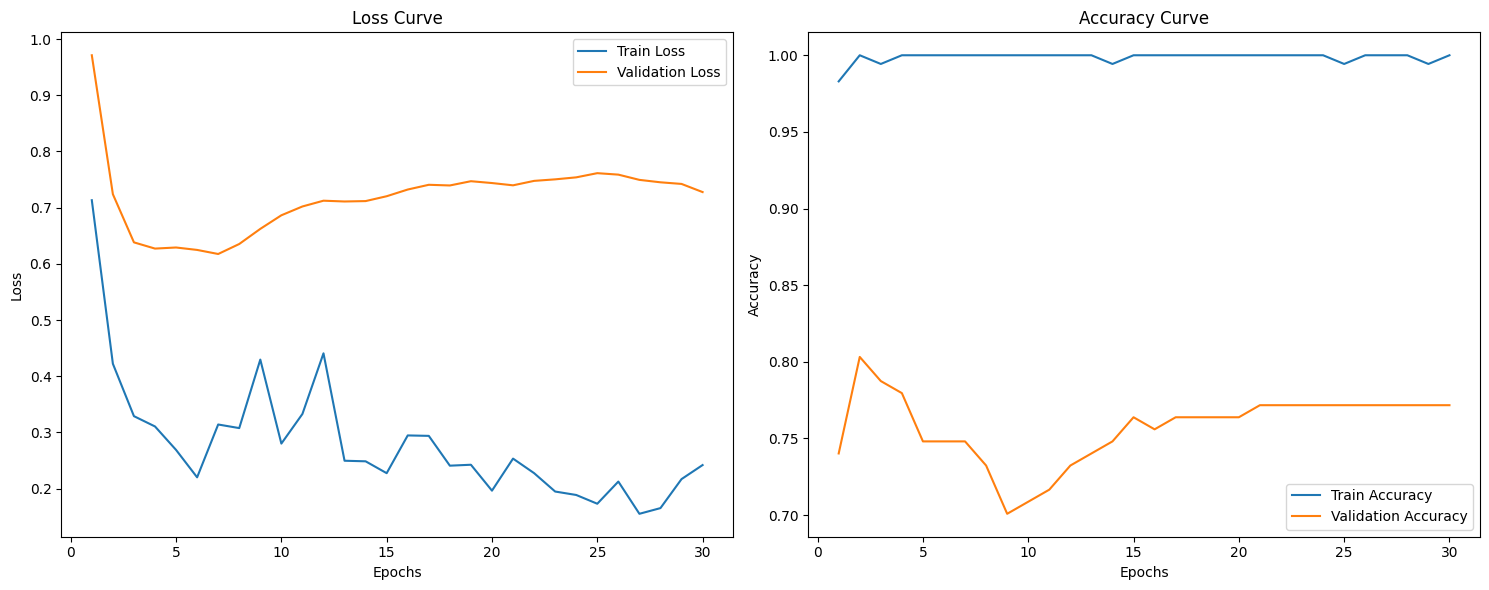


Models saved.

--- Final Test Set Performance (Teacher Model) ---
  Final Test Loss: 0.6446
  Final Test Accuracy: 0.7937


In [ ]:
#Plotting Training History
epochs_range = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(15, 6))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss_total'], label='Train Loss')
if val_loader and history['val_loss']:
     plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss Curve')

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
if labeled_loader and history['train_acc']:
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
if val_loader and history['val_acc']:
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()

if test_loader:
    print("\n--- Final Test Set Performance ---")
    print(f"  Final Test Loss: {final_test_loss:.4f}")
    print(f"  Final Test Accuracy: {final_test_acc:.4f}")
else:
    print("\nNo test set was available for final evaluation.")